# Notebook combinando fkgl (cmabiar por una métrica para español o francés) + semántica + bow

In [70]:
!pip -q install sentence-transformers textstat


In [71]:
from google.colab import drive
import os

# montar disco
drive.mount('/content/drive')
# Path del proyecto
PATH='/content/drive/MyDrive/iso4simplify'
os.chdir(PATH)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [85]:
# Escribe los nombres de tus columnas
COL_ID='text_id'
COL_COMPLEX='original'   # texto original
COL_REF='reference'        # texto simplificado
# Número de ejemplos a generar
N_EXAMPLES=3
# Nombre del dataset
DATASET='tsar2025'  #tsar2025, plaba, cochrane, cochraneauto

# Ruta relativa al fichero de training
PATH_TRAIN=f'data/{DATASET}/{DATASET}_train.csv'
# Ruta relativa de la template de prompts
TEMPLATE_PATH = "prompts/template_iso_few.md"
#spanihs, french
lang='english'

## Cargar dataset

In [86]:
import pandas as pd


df = pd.read_csv(PATH_TRAIN)
print("Train size:", df.shape)
#print("Train columns:", df.columns)

df = df[[COL_ID, COL_COMPLEX, COL_REF]]


Train size: (40, 4)


## Calculamos la similitud semántica entre complex-simple

In [87]:
from sentence_transformers import SentenceTransformer
import numpy as np

model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")
# Embeddings (normalizados para que dot product = cosine similarity)
emb_c = model.encode(df[COL_COMPLEX].tolist(), normalize_embeddings=True, show_progress_bar=True)
emb_s = model.encode(df[COL_REF].tolist(),  normalize_embeddings=True, show_progress_bar=True)
cosine_similarities = np.sum(emb_c * emb_s, axis=1)
# Cosine similarity por fila
df["sem_sim"] = cosine_similarities
df.head(2)

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

,text_id,original,reference,sem_sim
0,01-a2,Now NASA is working towards logging some of th...,Asteroids are small rocks in space. NASA is co...,0.901751
1,01-b1,Now NASA is working towards logging some of th...,Asteroids are rocks that fly through space. NA...,0.903584


## Calculamos la similitud-tfidf entre complex-simple

In [88]:

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


# Vectorizador BoW (TF-IDF). Puedes ajustar ngram_range para capturar frases.
vectorizer = TfidfVectorizer(
    lowercase=True,
    stop_words=lang,
    ngram_range=(1, 1),       # uni+bi-gramas suele ir mejor que solo (1,1)
    min_df=2
)

# Entrena vocabulario sobre ambos lados para no sesgar
all_texts = pd.concat([df[COL_COMPLEX], df[COL_REF]], ignore_index=True)
vectorizer.fit(all_texts)

Xc = vectorizer.transform(df[COL_COMPLEX])
Xs = vectorizer.transform(df[COL_REF])

# Similaridad coseno por fila (diagonal de la matriz de similitudes)
df["tfidf_sim"] = cosine_similarity(Xc, Xs).diagonal()
df.head()

,text_id,original,reference,sem_sim,tfidf_sim
0,01-a2,Now NASA is working towards logging some of th...,Asteroids are small rocks in space. NASA is co...,0.901751,0.655188
1,01-b1,Now NASA is working towards logging some of th...,Asteroids are rocks that fly through space. NA...,0.903584,0.675162
2,02-a2,"Earthquakes damage all structures, including b...",An earthquake means when the ground shakes a l...,0.806693,0.613557
3,02-b1,"Earthquakes damage all structures, including b...","Earthquakes damage all kinds of buildings, inc...",0.943416,0.742796
4,03-a2,"The Hunger Games are an annual event, which th...",The 'Hunger Games' happen every year. Why? To ...,0.785966,0.322374


## Estudimos la diferencia de fkgl entre complex-simple

In [89]:
import textstat

df["fkgl_complex"] = (
    df[COL_COMPLEX]
    .fillna("")
    .apply(lambda x: textstat.flesch_kincaid_grade(str(x)))
)

df["fkgl_ref"] = (
    df[COL_REF]
    .fillna("")
    .apply(lambda x: textstat.flesch_kincaid_grade(str(x)))
)

df["fkgl_diff"] = df["fkgl_complex"] - df["fkgl_ref"]

print("Mean FKGL original: ", df["fkgl_complex"].mean())
print("Mean FKGL ref: ", df["fkgl_ref"].mean())

df[["fkgl_complex", "fkgl_ref", "fkgl_diff"]].describe()

Mean FKGL original:  11.347928894862227
Mean FKGL ref:  8.73630758997572


,fkgl_complex,fkgl_ref,fkgl_diff
count,40.000000,40.000000,40.000000
mean,11.347929,8.736308,2.611621
std,3.354796,2.577422,2.866735
min,7.481086,4.113913,-2.505417
25%,8.939808,7.372410,0.761752
50%,10.729158,8.397860,1.985638
75%,12.389621,10.023487,4.037870
max,20.394783,16.471724,10.319682


<Axes: >

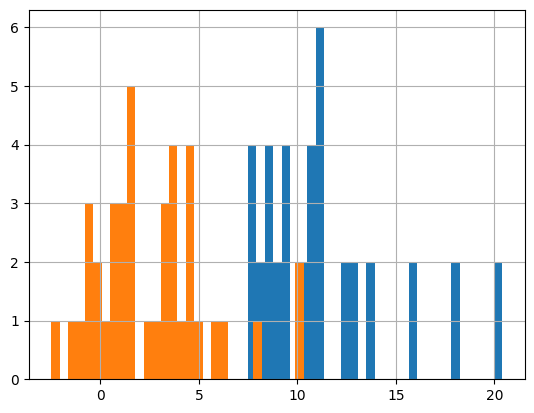

In [90]:
df["fkgl_complex"].hist(bins=30)
df["fkgl_diff"].hist(bins=30)


Excluir:

- fkgl_diff <0, porque no hay simplificación
- Excluir también outliers fuertes: fkgl_diff > Q3 + 1.5*IQR
- Excluir también outliers fuertes: fkgl_diff < Q1 - 1.5*IQR



In [91]:
mediana = df["fkgl_complex"].quantile(0.50)

q1 = df["fkgl_diff"].quantile(0.25)
q3 = df["fkgl_diff"].quantile(0.75)
iqr = q3 - q1

print("Q1 diff:", q1)
print("Q3 diff:", q3)
print("IQR diff:", iqr)

# El 1.5 × IQR viene de la regla propuesta por John Tukey para detectar valores atípicos (outliers) usando boxplots.
# 1.5 × IQR captura alrededor del 99% de los datos centrales
print("mediana:", mediana)

upper_bound = q3 + 1.5 * iqr

lower_bound = max(1.0, q1 - 1.5 * iqr)
print(lower_bound, upper_bound)

Q1 diff: 0.7617517214270189
Q3 diff: 4.037869940029984
IQR diff: 3.2761182186029654
mediana: 10.729158045977014
1.0 8.952047267934432


## Seleccionamos combinando fkgl+tfidf+similarity


We restrict candidate exemplars to source texts whose original readability is above the median FKGL, ensuring that selected examples reflect non-trivial simplification. Furthermore, readability gains (ΔFKGL) are constrained within Tukey’s interquartile range criterion (Q1 − 1.5·IQR to Q3 + 1.5·IQR) to exclude extreme transformations that may correspond to aggressive rewriting or information loss. This filtering step ensures that few-shot examples represent typical and controlled simplification patterns within the dataset.

Since our objective is simplification, we constrain readability gains to be strictly positive (ΔFKGL > 0), ensuring that selected examples reflect actual reductions in complexity. The upper bound is determined using Tukey’s 1.5·IQR criterion to exclude extreme transformations.


In [92]:
df_filtered = df[
    (df["fkgl_complex"] >= mediana) &
    (df["fkgl_diff"] >= lower_bound) &
    (df["fkgl_diff"] <= upper_bound)
]
print(df_filtered.shape)
df_filtered.head()

# Quitamos los que son muy similares léxicamente
df_filtered_bow = df_filtered[df_filtered["tfidf_sim"] < 0.9]

top_fkgl_sem_bow = df_filtered_bow.sort_values("sem_sim", ascending=False).head(N_EXAMPLES)
top_fkgl_sem_bow

(15, 8)


,text_id,original,reference,sem_sim,tfidf_sim,fkgl_complex,fkgl_ref,fkgl_diff
33,17-b1,Having an increased awareness of the possible ...,An increased knowledge of the possible differe...,0.949027,0.544370,20.394783,16.471724,3.923058
21,11-b1,Much of today's business is conducted across i...,Much of today's business is carried out across...,0.945204,0.550834,18.060000,13.327549,4.732451
1,01-b1,Now NASA is working towards logging some of th...,Asteroids are rocks that fly through space. NA...,0.903584,0.675162,12.704638,11.183367,1.521270


## Generamos el prompt


In [93]:
from pathlib import Path

DIR_PROMPTS='prompts'
os.makedirs(DIR_PROMPTS, exist_ok=True)


template_few = Path(TEMPLATE_PATH).read_text(encoding="utf-8")
examples = []

for i, row in top_fkgl_sem_bow.iterrows():
    examples.append({
        "id": row[COL_ID].strip(),
        "input": row[COL_COMPLEX].strip(),
        "output": row[COL_REF].strip()
    })

prompt_fewshot = template_few.format(
    ID_1=examples[0]["id"],
    EXAMPLE_1_INPUT=examples[0]["input"],
    EXAMPLE_1_OUTPUT=examples[0]["output"],

    ID_2 =examples[1]["id"],
    EXAMPLE_2_INPUT=examples[1]["input"],
    EXAMPLE_2_OUTPUT=examples[1]["output"],

    ID_3 =examples[0]["id"],
    EXAMPLE_3_INPUT=examples[2]["input"],
    EXAMPLE_3_OUTPUT=examples[2]["output"],
    INPUT_TEXT="{INPUT_TEXT}"  # placeholder para inferencia
)

OUTPUT_PATH = f"prompts/{DATASET}_fkgl_few_{N_EXAMPLES}.md"

with open(OUTPUT_PATH, "w", encoding="utf-8") as f:
    f.write(prompt_fewshot)

print("Prompt saved to:", OUTPUT_PATH)

Prompt saved to: prompts/tsar2025_fkgl_few_3.md


También los podemos guardar en un fichero txt.

In [94]:

output_file = DIR_PROMPTS+f"/{DATASET}_fkgl_{N_EXAMPLES}.txt"

with open(output_file, "w", encoding="utf-8") as f:

    for idx, (_, row) in enumerate(top_fkgl_sem_bow.iterrows(), start=1):

        f.write("="*50 + "\n\n")

        f.write(f"EXAMPLE {idx} ({row[COL_ID]})\n")
        f.write("ORIGINAL:\n")
        f.write(str(row[COL_COMPLEX]).strip() + "\n\n")

        f.write("SIMPLIFIED TEXT:\n")
        f.write(str(row[COL_REF]).strip() + "\n\n")

    f.write("="*50 + "\n")

print("Fichero generado en:", os.path.abspath(output_file))

Fichero generado en: /content/drive/MyDrive/iso4simplify/prompts/tsar2025_fkgl_3.txt
